### Karim Abd El Salam K-14258
### Maximilian Suliga K-14026

# Introduction

Algorithmic trading is the use of software programs to automatically place orders on financial assets while ensuring the “best execution”. Apart from better execution, algorithmic trading also has the potential to trade much more, faster and cheaper than a flesh-and-bones trader could do. Around 80% of trades in equity (Real Finance, 2019) and 92% in Foreign Exchange (Kissell, 2020) are conducted by algorithms. However, algorithmic trading has also shown to be prone to systemic risk. The Flash Crash of May 2010 is regarded to be a prime example of this risk (International Organization of Securities Commissions, 2011).

While being limited to institutional investors only at its first implementation, the advancement in technology has made it possible for retail investors to conduct algorithmic trading as well (Shadmehry, 2021). A number of websites are already offering the possibility of algorithmic trading for retail investors without any knowledge of coding as well as APIs that simplify the process of coding (Shadmehry, 2021). A collection of indicators that can be used for generating trading signals is provided for example by Fidelity (2022). 

Before implementing an algorithm to conduct trades, it should be tested whether it is profitable at all, whether it beats the benchmark of "Buy and Hold" and which parameters are maximizing the returns. In this paper, we combine the Shiryaev–Zhou Index with the Aroon Indicator to automatically trade on the Nasdaq Index from the beginning of 2015 till the end of 2021. Section 2 reviews the literature on the indicators and Section 3 the data used in our study. Section 4 presents the methodology and our strategy conducted, while Section 5 discusses the results of it. Section 6 concludes.

# Literature Review

In their 2019 paper, Hui & Chan propose the Shiryaev–Zhou index on different major stock indices and securitized real estate indices. While their results were mixed, the indicator still beat the "Buy and Hold" Benchmark overall. Trade Signals using the Shiryaev–Zhou index are generated by calculating:

$\hat{\mu_i} (n) = \frac{\hat{\alpha_i} (n)}{{\hat{\sigma_i}}^2 (n)} - 0.5$ 

with 

$\hat{\alpha_i} (n) = 252 \bar{r_i} (n) \\ \hat{\sigma_i}^2 (n) = 252{s_i}^2 (n)$

where 

$\bar{r_i} (n) = {\text {average of a rolling window of size}} \ n \\ {s_i}^2 (n) = {\text {standard deviation of a rolling window of size}} \ n$


for a rolling window of variable size. If $\mu$ changes from $\geq 0$ to $<0$ one unit of stock is sold, while one unit stock is bought when $\mu$ changes from $<0$ to $\geq 0$.


Despite its underperformance in papers like Lu’s (2022), the Aroon Indicator has established itself as a classic indicator for technical analysis. For a time window of variable size, the number of time periods the last peak was ago is called the Aroon Up, while the last time a low was ago is called the Aroon Down. These values are then standardized by calculating:

${\text {Aroon-Up}} = \frac{(j - Periods \ Since \ Highest \ High)} {j} \times 100 \\ {\text {Aroon-Down}} = \frac{(j - Periods \ Since \ Lowest \ Low)} {j} \times 100$

with

$j = {\text {window size}}$

Buying signals are then generated when the Aroon Up is above and the Aroon Down below a certain value,  typically 70 and 30 respectively (Lu, 2022), while selling signals are generated if both Aroon Up is below and Aroon Down above the certain value respectively.


# Description of Dataset


We use the Nasdaq Index from the beginning of 2015 till the end of 2021 as our considered financial asset. The daily Opening Prices, Highs, Lows, Closing Prices, Trading Volume, Dividends and Stock Splits are provided by Yahoo (2022). This paper focuses on the Closing Price and Volume only. A simple graph shows the development of the Nasdaq from the beginning till the end of our selected time period. We then cut off the most recent half year from the dataset, as it is the combination of financial quarters that comes closest to the typical sample size of 5% of the whole dataframe. While this most recent half year will be used to evaluate the performance of our strategy with our benchmark of “Buy and Hold”, we will use the remaining data first to estimate the optimal parameters.

In [1]:
# First of all we import the library that we need
import numpy as np
import pandas as pd
#!pip install yfinance
import yfinance as yf
import math
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Thanks to "yfinance" library we import the time series of the Nasdaq index directly from Yahoo Finance database. The time series
# goes from  01/01/2015 to 31/12/2021
nasdaq = yf.Ticker("^IXIC")
hist = nasdaq.history(start="2015-01-01", end="2021-12-31")
print(hist.columns.values)

['Open' 'High' 'Low' 'Close' 'Volume' 'Dividends' 'Stock Splits']


In [3]:
# Let's select only the columns that we are interested to analyze: "Close" and "Volume"
nasdaq_values=hist.iloc[0:,3:5]
print(nasdaq_values)

                   Close      Volume
Date                                
2014-12-31   4736.049805  1515600000
2015-01-02   4726.810059  1435150000
2015-01-05   4652.569824  1794470000
2015-01-06   4592.740234  2167320000
2015-01-07   4650.470215  1957950000
...                  ...         ...
2021-12-23  15653.370117  3918200000
2021-12-27  15871.259766  3730120000
2021-12-28  15781.719727  3623600000
2021-12-29  15766.219727  3694500000
2021-12-30  15741.559570  3732730000

[1763 rows x 2 columns]


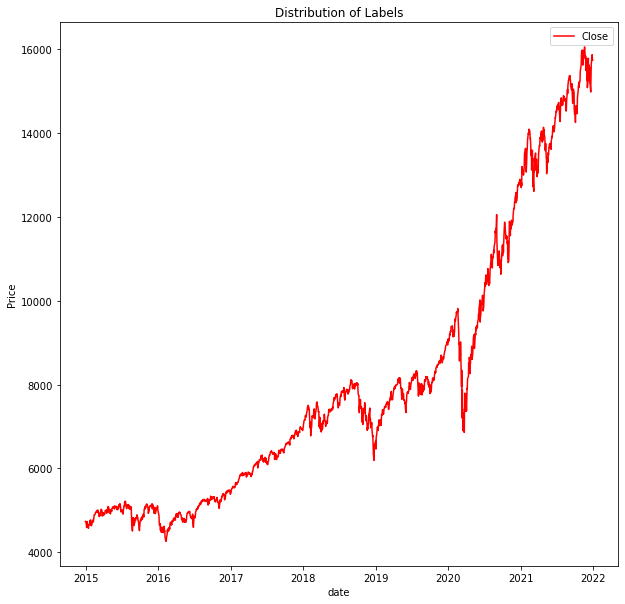

In [4]:
# Let's check how the plot of the "Close" prices of Nasdaq dataframe looks like:
plt.figure(figsize=(10, 10))

plt.plot(hist['Close'], color='r', label='Close')
plt.xlabel("date")
plt.ylabel("Price")
plt.title('Distribution of Labels')
plt.legend()

plt.show()

In [5]:
# Number of trading days in the selected dataframe
len(nasdaq_values) 

1763

In [6]:
# We consider the 5% as a typical out of sample size
len(nasdaq_values)*0.05

88.15

In [7]:
# To account for eventual seasonality check how much half a year would be (assuming a year has 252 trading days)
126/len(nasdaq_values)

0.07146908678389109

In [8]:
# Let's now separate our Dataframe into "Train" and "Test" dataframes
nasdaq_train = nasdaq_values.loc[:'2021-06-30'] # Useful to find optimal rolling window
nasdaq_test = nasdaq_values.loc['2021-07-01':] # Useful to check how well the optimal rolling window performs

print(nasdaq_train.head())
print(nasdaq_test.head())

                  Close      Volume
Date                               
2014-12-31  4736.049805  1515600000
2015-01-02  4726.810059  1435150000
2015-01-05  4652.569824  1794470000
2015-01-06  4592.740234  2167320000
2015-01-07  4650.470215  1957950000
                   Close      Volume
Date                                
2021-07-01  14522.379883  4371620000
2021-07-02  14639.330078  3731730000
2021-07-06  14663.639648  4464780000
2021-07-07  14665.059570  4582030000
2021-07-08  14559.780273  4550600000


# Methodology 

We generate trading signals by combining the trading signals from the lesser known Shiryaev–Zhou index and the classic Aroon-Indicator. We then adjust the signals by the change in Volume, as it is well known that the publication of financial information that significantly over- or underperforms the market’s expectations results in large, persisting price changes and increase in trading volume, see for example Bamber (1986). The idea is to trade more financial assets when these price changes are indicated to come from significant news like financial publications, which in turn will be indicated by an increase of trading volume. 

The signals of both considered indices are saved as numbers, where 1 indicates a buying signal, 0 a holding signal and -1 a selling signal. The unadjusted number of financial assets traded is then the sum of both numbers. The idea is to find strong trend changes when both indicators are giving the same sign, while small trend changes are found when only one indicator is giving a sign. Contradictory trading signals cancel each other out, so that trades are only made if at least one indicator gives a signal into a specific direction.

This number is then multiplied by the relative change in trading volume, rounded to full numbers. 
For example, in a situation where one indicator is giving no trading signal, the other gives a buying signal and today’s trading volume is 1.8 times as high than yesterday’s, $1 \times 1.8 \approx 1 \times 2 = 2$ financial assets will be bought.

For testing our strategy, we consider different rolling windows of sizes 5, 10, 15, 20, 35, 40, 50 and 60. In addition, we also consider deviations from the suggested Aroon-Indicator values by also considering 80 and 90 for the Aroon-Up and 20 and 10 for the Aroon-Down respectively.

We evaluate each combination of parameters by their Sharpe Ratio, Information Ratio, Maximum Drawdown and Standard Deviation. In addition, we also report the number of trades done for each parameter combination. We consider a starting capital of 1 Million US Dollars, an annual risk-free rate of 0.1% and trading costs of 0.02% of the transaction price. Each parameter combination is then ranked by its Sharpe Ratio. We then examine the best performing parameter combination compared to the “Buy and Hold” benchmark for both the in-sample and out-of-sample period, with the out-of-sample period comparison representing our strategy’s general performance.

In our first approach, we have started our trading strategy with all capital being held in cash in the starting period. We have found that the Buy and Hold strategy is clearly beating our strategy, because of the high amount of "dead capital" that we are holding when buying only few of the assets that have a price much lower than our starting capital every day. This evidence led us to start investing all money available into the financial asset and then use our trading strategy to adjust our portfolio automatically. As results have improved tremendously, we stick with this approach and present only the results gathered from it. 


In [9]:
# Here we define the values of our parameters.
window_sizes=[5, 10, 15, 20, 35, 40, 50, 60] # This will be our rolling window
ups=[70, 80, 90] # This is the higher treshold for Aroon Indicator
downs = [10, 20, 30] # This is the lower treshold for Aroon Indicator

In [10]:
# We define a useful function that we will use later in our code.

# The input of "peak_low_length" are:
# 1) peak_low = list of peaks / lows
# 2) df = dataframe
# 3) size = window
# We use this function to calculate the periods since the highest high / lowest low, inside the window specified
def peak_low_length(peak_low, df, size): ### peak_low= List of Peaks and list of Lows
    length_number=[]
    for i in range (size-1, len(peak_low)-1):
        j=i
        while peak_low[i] != df[j]:
            j = j- 1
        length_number.append(i-j)
    return length_number




In [11]:
# We define three other useful functions for calculating our performance ratios.

# The input of "sharpe" are:
# 1) returns= list of (daily) return of our portfolio.
# 2) rf= risk free (daily) rate.
# This function is used to define anothe measure of performance the "Sharpe Ratio". This ratio calculate the average excess
# return per unity of volatility (or any risk measure, in our case will be standard devation).
def sharpe(returns, rf, portfolio_values, base):
    daily_rf= (1+rf)**(1/252)-1
    volatility = np.std(returns, ddof=1)
    sharpe_ratio = (((portfolio_values[-1] / base)**(1/len(portfolio_values))-1)- daily_rf) / volatility
    return sharpe_ratio


# The input of "information_ratio" are:
# 1) returns= list of (daily) return of our portfolio.
# 2) benchmark_returns= list of (daily) return of the benchamrk
# This function will be used for define the "Information Ratio" as a (daily) measure of performance. In detail this indicator
# show us how well our portfolio is doing compared to the benchmark and taking into account the volatility of those returns.
def information_ratio(returns, benchmark_returns):
    return_difference = [x - y for (x, y) in zip(returns, benchmark_returns)]
    volatility = np.std(return_difference, ddof=1)
    information_ratio = np.mean(return_difference)/ volatility
    return information_ratio



# The input of "max_dd" is:
# 1) prices = list of prices of our df
# We use this function to calculate the max drowdown
def max_dd(prices):
    peak_current = prices[0]
    max_dd = 0
    for p in prices:
        if p >= peak_current:
            peak_current = p
        dd = (peak_current - p) / peak_current
        if dd > max_dd:
            max_dd = dd
    return max_dd

In [16]:
# Let's now define our main function that will perform the main work of our stategy.

# The input of "calculate_ratios" are:
# 1) df= is the dataframe of the Nasdaq. The only column that we use are "Close" price and "Volume"
# 2) size_values= is the window
# 3) capital= is the inital capital that we use in the strategy
# 4) up= is the up treshold of the Aroon Indicator
# 5) down= is the low treshold of the Aroon Indicator
# 6) add_benchmark= default value as "no", if "yes" the function calculate all the performance indicator also for the benchmark
# This function is the main core of our project. As it's possible to read at the followin lines of code, the function calculate
# trading signals, ratios, the value of the portfolio etc...

def calculate_ratios(df,size_values,capital, up, down, add_benchmark = 'no'):

  #lists containing the performance measures for each parameter combination
  sharpe_ratios = [] 
  information_ratios = [] 
  end_capitals=[]
  maximum_drawdowns = []
  portfolio_stds=[]
  trade_numbers = []
  output_index = []
  aroon_trades = []


  


  for j in size_values:  # j in the moving window
    for l in down: # l in the down treshold for Aroon Indicator
      for m in up: # m in the up treshold for Aroon Indicator
        temp =[j ,l, m]
        temp = ', '.join(str(x) for x in temp)
        output_index.append(temp)

    
        portfolio = [] # Number of assets
        portfolio_value = [] # Worth of the portfolio
        portfolio_return = [] # Daily return of portfolio
        portfolio_cumulative_return = [] # Cumulative return of portfolio
        start_capitalA = capital # Start capital

        # Benchmark portfolio measures
        benchmark_value = [math.floor(start_capitalA / df['Close'][j-1])*df['Close'][j-1]/(1+tr_cost)] # Money invested on the "Buy and Hold" strategy after transaction costs  
        benchmark_return = []
        cumulative_benchmark_return = [1]
        for i in range (j, len(df)-1):
          benchmark_return.append(df['Close'][i] / df['Close'][i-1] - 1) # Benchmark daily return
          benchmark_value.append(benchmark_value[i-j] * (1 + benchmark_return[i-j])) # Value of the Benchmark portfolio with "Buy and Hold" strategy
          cumulative_benchmark_return.append(cumulative_benchmark_return[i-j] * (1+benchmark_return[i-j]))

        


        # Values of the Shiryaev-Zhou Index
        SZ=df['Close'].rolling(window=j).mean() / df['Close'].rolling(window=j).var() -0.05 



        # list of converted Shiryaev-Zhou Index values into signals
        signals = []
        for i in range (0, len(df)-j):
                if (SZ[i] < 0 and SZ[i-1] >= 0):
                    signals.append(-1)
                elif (SZ[i] >= 0 and SZ[i-1] < 0):
                    signals.append(1)
                else:
                    signals.append(0)


        # List of peaks and lows inside the window_size
        peaks = df['Close'].rolling(window=j).max()
        lows = df['Close'].rolling(window=j).min()

        # Duration of how long the last peak/low was ago
        peak_length = peak_low_length(peaks.tolist(), df['Close'].tolist(), j)
        low_length = peak_low_length(lows.tolist(), df['Close'].tolist(), j)

        aroon_up = []
        aroon_down = []

        for i in range (0, len(df)-j):
          aroon_up.append( ((j - peak_length[i])/ j)*100)
          aroon_down.append( ((j-low_length[i])/ j)*100)




        # List of signals generated by the Aroon Indicator
        signals_2 = []
        for i in range (0, len(df)-j):
            if aroon_up[i]>=m and aroon_down[i]<=l:
              signals_2.append(1)
            elif aroon_up[i]<=m and aroon_down[i]>=l:
              signals_2.append(-1)
            else:
                signals_2.append(0) 


        # Initial values of our portfolio that follows the strategy
        for i in range (0, len(df)-j):
          if len(portfolio) ==0:
            portfolio.append(math.floor(start_capitalA / (df['Close'][i+j-1]*(1+tr_cost))))
            portfolio_value.append(math.floor(start_capitalA / df['Close'][i+j-1])*df['Close'][i+j-1]/(1+tr_cost))    
            portfolio_cumulative_return.append(1)
            trade_number = 1
            start_capitalA -= math.floor(start_capitalA / df['Close'][i+j-1])*df['Close'][i+j-1]/(1+tr_cost)
            continue

          # Combine the signals, portfolio receives the number of assets traded and capital is updated by the value together with transaction costs 
          if signals[i-1] + signals_2[i-1] == 2 and start_capitalA- 2 * (1 + tr_cost) * round(df['Volume'][i+j] / df['Volume'][i-1+j]) * df['Close'][i+j] >=0 :
            portfolio.append(portfolio[i-1]+ 2 * round(df['Volume'][i+j] / df['Volume'][i-1+j]) )
            start_capitalA-= 2 * (1 + tr_cost) * round(df['Volume'][i+j] / df['Volume'][i-1+j]) * df['Close'][i+j] 
            trade_number += 2*round(df['Volume'][i+j] / df['Volume'][i-1+j])
          elif signals[i-1] + signals_2[i-1] == 1 and start_capitalA- 1 * (1 + tr_cost) * round(df['Volume'][i+j] / df['Volume'][i-1+j]) * df['Close'][i+j] >=0:
            portfolio.append(portfolio[i-1] + round(df['Volume'][i+j] / df['Volume'][i-1+j]) )
            start_capitalA-= 1 * (1 + tr_cost) * round(df['Volume'][i+j] / df['Volume'][i-1+j]) * df['Close'][i+j]
            trade_number += 1*round(df['Volume'][i+j] / df['Volume'][i-1+j])
          elif signals[i-1] + signals_2[i-1] == -1 and portfolio[-1] >= 1:  # Shortselling constraint for one sell signal
            portfolio.append(portfolio[i-1] - round(df['Volume'][i+j] / df['Volume'][i-1+j])) 
            start_capitalA += 1 * (1 - tr_cost) * round(df['Volume'][i+j] / df['Volume'][i-1+j]) * df['Close'][i+j]
            trade_number += 1*round(df['Volume'][i+j] / df['Volume'][i-1+j])
          elif signals[i-1] + signals_2[i-1] == -2 and portfolio[-1] >= 2: # Shortselling constraint for two sell signals
            portfolio.append(portfolio[i-1] -2 * round(df['Volume'][i+j] / df['Volume'][i-1+j] ))
            start_capitalA+= 2 * (1 - tr_cost) * round(df['Volume'][i+j] / df['Volume'][i-1+j]) * df['Close'][i+j] 
            trade_number += 2*round(df['Volume'][i+j] / df['Volume'][i-1+j])
          else:
            portfolio.append(portfolio[i-1])
          
          # Update the value of the portfolio,the return of portfolio and the cumulative return
          portfolio_value.append(df['Close'][i+j] * portfolio[i] + start_capitalA) 
          portfolio_return.append(portfolio_value[i] / portfolio_value[i-1] -1)
          portfolio_cumulative_return.append(portfolio_cumulative_return[i-1] * (1+portfolio_return[i-1]))

        

        
        
        end_capital = portfolio_value[-1]
        
        # Append the value of the "Sharpe Ratio" using the function defined before
        sharpe_ratios.append(sharpe(portfolio_return, rf, portfolio_value, start_capitalA))
        # Append the value of the "Information Ratio" using the function defined before
        information_ratios.append(information_ratio(portfolio_return, benchmark_return))
        # Append the value of the "Max Draw Down" using the function defined before
        maximum_drawdowns.append(max_dd(portfolio_value))

        end_capitals.append(end_capital)
        # Append the value of the "Standard Deviation"
        portfolio_stds.append(np.std(portfolio_return, ddof = 1))
        # Append the number of trades
        trade_numbers.append(trade_number)
        
  # Let's put all this information in a table      
  output_table = pd.DataFrame({'parameters':output_index})
  output_table.set_index('parameters', inplace = True)
  output_table['daily sharpe ratio'] = sharpe_ratios
  output_table['daily information ratio'] = information_ratios
  output_table['maximum drawdown'] = maximum_drawdowns
  output_table['portfolio standard deviation'] = portfolio_stds
  output_table['number of trades'] = trade_numbers
  output_table.sort_values(by=['daily sharpe ratio', 'parameters'], ascending = False, inplace = True)


  # Plots comparing the best Portfolio (depending on the parameters selected) against the "Buy and Hold" Benchmark
  if add_benchmark == 'yes':
    df = df.iloc[j: , :]
    df['portfolio_value'] = portfolio_value
    df['benchmark_value'] = benchmark_value
    plt.figure(figsize=(10, 10))
    plt.plot(df['benchmark_value'], color='r', label='Nasdaq Close')
    plt.plot(df['portfolio_value'], color='g', label='Portfolio')
    plt.xlabel("date")
    plt.ylabel("price")
    plt.title('portfolio value performance')
    plt.legend()

    plt.show()

    df['portfolio_cumulative_return'] = portfolio_cumulative_return
    df['benchmark_cumulative_return'] = cumulative_benchmark_return
    plt.figure(figsize=(10, 10))
    plt.plot(df['benchmark_cumulative_return'], color='r', label='Nasdaq Return')
    plt.plot(df['portfolio_cumulative_return'], color='g', label='Portfolio Cumulative Return')
    plt.xlabel("date")
    plt.ylabel("cumulative return")
    plt.title('portfolio cumulative return performance')
    plt.legend()

    plt.show()


    df = df.iloc[1: , :]
    df['portfolio_return'] = portfolio_return
    df['benchmark_return'] = benchmark_return
    plt.figure(figsize=(10, 10))
    plt.plot(df['benchmark_return'], color='r', label='Nasdaq Return')
    plt.plot(df['portfolio_return'], color='g', label='Portfolio Return')
    plt.xlabel("date")
    plt.ylabel("return")
    plt.title('portfolio return performance')
    plt.legend()

    plt.show()



    # Add all the measures to the output table
    benchmark_df = pd.DataFrame(
    {
        'daily sharpe ratio': [sharpe(benchmark_return, rf, benchmark_value, start_capitalA)],
        'daily information ratio': [0],
        'maximum drawdown' : [max_dd(benchmark_value)],
        'portfolio standard deviation': [np.std(benchmark_return)],
        'number of trades': [1]
    },
    index=['benchmark'])

    output_table = pd.concat( [output_table, benchmark_df])



  # Return the output table
  return output_table

In [17]:
# Define the initial parameters
start_capital = 1000000 # the capital to invest into the strategy
rf = 0.001 # risk-free rate
tr_cost = 0.0002 #Transaction cost (share of asset purchase)

# Let's use our function:
parameter_comparison = calculate_ratios(nasdaq_train, window_sizes, start_capital, ups, downs,)
parameter_comparison

,daily sharpe ratio,daily information ratio,maximum drawdown,portfolio standard deviation,number of trades
parameters,,,,,
"10, 30, 70",0.221521,-0.004983,0.288882,0.011899,1192
"20, 30, 70",0.188279,-0.006550,0.291272,0.011673,1024
"20, 30, 80",0.166261,-0.011550,0.288707,0.010829,1119
"10, 30, 80",0.162974,-0.009199,0.287854,0.011229,1260
"15, 30, 70",0.156478,-0.006823,0.291429,0.011668,1043
"20, 30, 90",0.147949,-0.028826,0.177206,0.007073,1130
"20, 20, 80",0.147285,-0.026499,0.189032,0.007578,1158
"10, 20, 70",0.139176,-0.013298,0.253838,0.010087,1217
"20, 20, 70",0.139087,-0.011955,0.290459,0.010854,1066


In [18]:
pd.set_option('display.max_rows', None)
parameter_comparison

,daily sharpe ratio,daily information ratio,maximum drawdown,portfolio standard deviation,number of trades
parameters,,,,,
"10, 30, 70",0.221521,-0.004983,0.288882,0.011899,1192
"20, 30, 70",0.188279,-0.006550,0.291272,0.011673,1024
"20, 30, 80",0.166261,-0.011550,0.288707,0.010829,1119
"10, 30, 80",0.162974,-0.009199,0.287854,0.011229,1260
"15, 30, 70",0.156478,-0.006823,0.291429,0.011668,1043
"20, 30, 90",0.147949,-0.028826,0.177206,0.007073,1130
"20, 20, 80",0.147285,-0.026499,0.189032,0.007578,1158
"10, 20, 70",0.139176,-0.013298,0.253838,0.010087,1217
"20, 20, 70",0.139087,-0.011955,0.290459,0.010854,1066


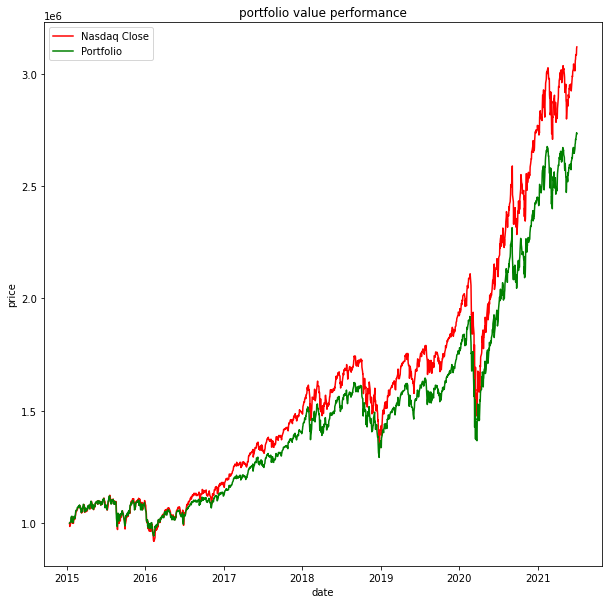

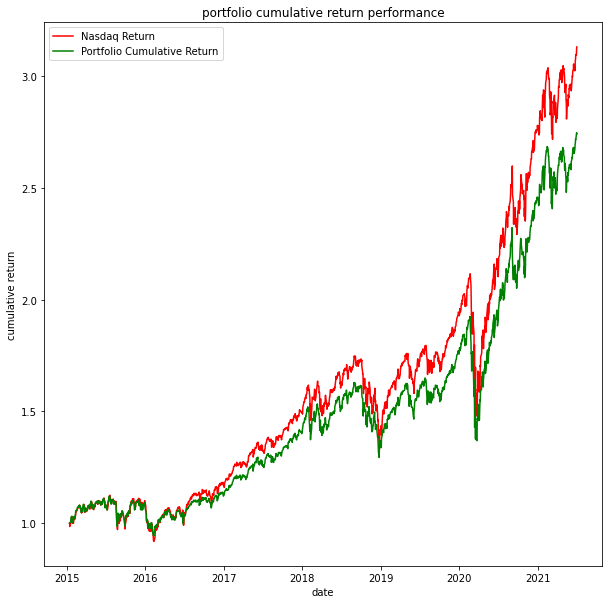

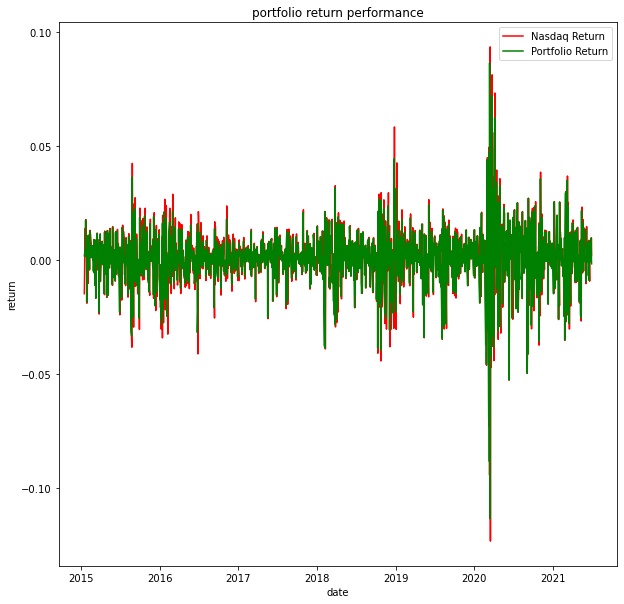

,daily sharpe ratio,daily information ratio,maximum drawdown,portfolio standard deviation,number of trades
"10, 30, 70",0.221521,-0.004983,0.288882,0.011899,1192
benchmark,0.208604,0.000000,0.301157,0.013024,1


In [19]:
# Compare the winner from the table above with the "Buy and Hold" Benchmark

size_10 = [10]
up_70= [70]
down_30 = [30]
calculate_ratios(nasdaq_train, size_10, start_capital, up_70, down_30,add_benchmark =  'yes')

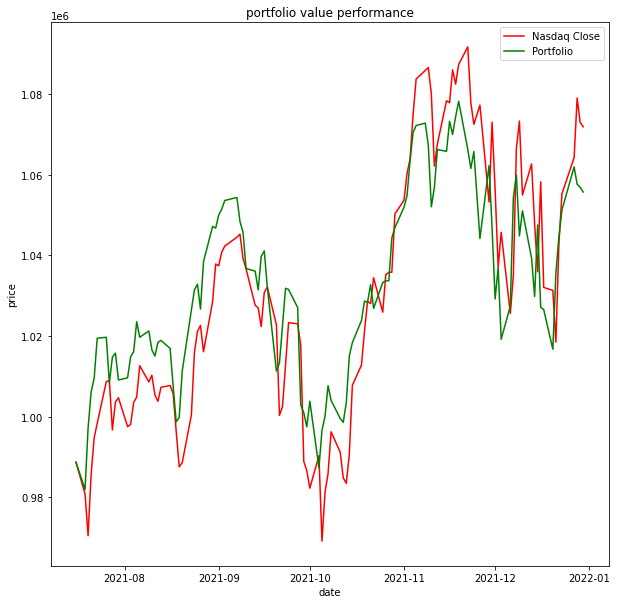

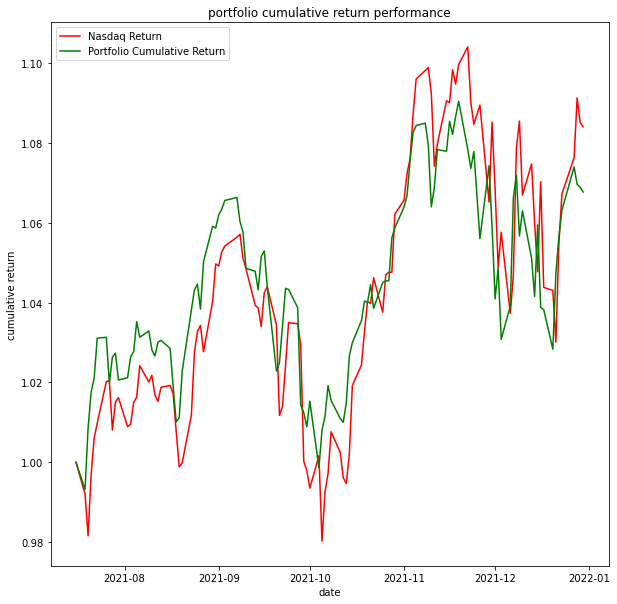

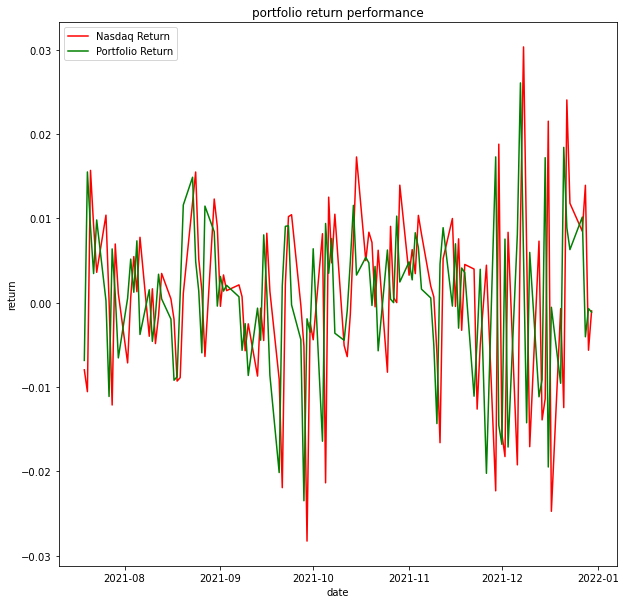

,daily sharpe ratio,daily information ratio,maximum drawdown,portfolio standard deviation,number of trades
"10, 30, 70",1.236753,-0.010621,0.063537,0.008736,85
benchmark,1.059969,0.000000,0.072774,0.010273,1


In [20]:
# Verify the performance with the out of sample dataset
calculate_ratios(nasdaq_test, size_10, start_capital, up_70, down_30,add_benchmark =  'yes')

# Results

Information ratios are negative, which indicates that the expected return of every parameter combination of our strategy is lower than that of the benchmark. A clear negative relationship can be seen between the size of the moving window and the Standard Deviation as well as the number of trades. This is to be expected, since generally smaller windows result in more trades, as less periods are needed to indicate a change in trend, and more trades result in higher volatility. There also seems to be a positive relationship between the Maximum Drawdown and the Standard Deviation, which also makes perfect sense. Omitting large losses omits the overall volatility of a portfolio.

Our strategy is beats the “Buy and Hold” Benchmark in both the in-sample and out-of-sample dataset. The graphs give clear evidence that this is mainly due to the lower volatility, as overall return is lower than that of the benchmark. Checking the numbers, Information Ratio is negative for our strategy in both cases, however Maximum Drawdown as well as Standard Deviation are slightly lower for our Strategy in both cases. Our strategy seems therefore to be rather conservative compared to the benchmark.

# Conclusion

While our strategy sounded promising to ourselves in the beginning, we had to face the fact that it was clearly underperforming the simple “Buy and Hold” strategy regarding return only. However, our strategy provided a lower standard deviation, which made it less risky than the benchmark and hence better when considering the Sharpe Ratio. This study showed how theory and practice, or ideas and performance can differ depending on the measure chosen. It also showed how different performance indicators may indicate different choices of parameters for a given strategy, and what role parameters can take.

Further research could investigate the shortcomings of our strategy with the aim to turn around the performance considering return. Other assets could be taken into consideration, as well as different transaction costs scenarios or higher size of orders, possibly up  to the full amount of capital available. Apart from this broader investigation, a deeper analysis could also yield important insights by evaluating for example the moment of trades, the relevance of the volume adjustment or the individual indicators. 


# References

Bamber, L. S. (1986). The Information Content of Annual Earnings Releases: A Trading Volume Approach. Journal of Accounting Research, 40-56.


Fidelity. (2022). Technical Indicator Guide. Retrieved from Fidelity: https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/overview


Hui, E. C., & Chan, K. K. (2019). Alternative trading strategies to beat ‘‘buy-and-hold’’. Physica A.


International Organization of Securities Commissions. (2011, July 6). Public Reports. Retrieved from International Organization of Securities Commissions: https://www.iosco.org/library/pubdocs/pdf/IOSCOPD354.pdf


Kissell, R. (2020). Algorithmic Trading Methods. Elsevier.


Lu, J. (2022). Exploring Classic Quantitative Strategies. Cornell University.


Real Finance. (2019, January 1). Algo Trading dominates 80% Of Stock Market. Retrieved from Seeking Alpha: https://seekingalpha.com/article/4230982-algo-trading-dominates-80-percent-of-stock-market


Shadmehry, C. (2021, June 18). How Profitable is Algorithmic Trading in 2021? Retrieved from Medium: https://medium.com/automated-trading/how-profitable-is-algorithmic-trading-in-2021-1b63489cd70a


Yahoo. (2022, May 30). NASDAQ Composite (^IXIC): Historical Data. Retrieved from yahoo! finance: https://finance.yahoo.com/quote/%5EIXIC/history?p=%5EIXIC

# Distribution of Work

In [21]:
task=['Introduction', 'Literature Review', 'Methodology', 'Function Building', 'Debugging', 'Discussion of Results' , 'Conclusion']
student=['Max', 'Karim & Max', 'Karim & Max', 'Max', 'Karim', 'Karim', 'Karim & Max']

work_distribution = pd.DataFrame(
{'student': student,
    'task': task,})
work_distribution.set_index('task', inplace = True)
work_distribution

,student
task,
Introduction,Max
Literature Review,Karim & Max
Methodology,Karim & Max
Function Building,Max
Debugging,Karim
Discussion of Results,Karim
Conclusion,Karim & Max
